# <i class="fa-solid fa-dice"></i> Resampling Strategies

As neuropsychologists, you will be well aware of the challenges involved in data collection — time, cost, and the complexities of experimental design often make large datasets hard to come by. However, robust predictive modeling is critical not only because extensive datasets can be rare, but also because ensuring that models generalize well to new data is often an essential question.

Resampling methods offer a powerful approach to assess model performance and mitigate overfitting. Rather than relying on a single train-test split, which can yield performance estimates that vary significantly depending on the split, resampling techniques repeatedly draw samples from your data. This process simulates multiple independent training and test sets, providing a more stable and reliable evaluation of your model.


```{admonition} Resampling Strategies
:class: hint

Two of the most widely used resampling methods are:

- *Cross validation*: Creating non-overlapping subsets for training and testing
- *Bootstrapping*: Sampling with replacement, resulting in (partly) overlapping samples
```

## The data

We will use a dataset you are already familiar with from last semester: The [Iris](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) dataset which contains 150 samples from three species of the iris plant (iris setosa, iris virginica and iris versicolor). The data contains four features: the length and the width of the sepals and petals (in centimeters).

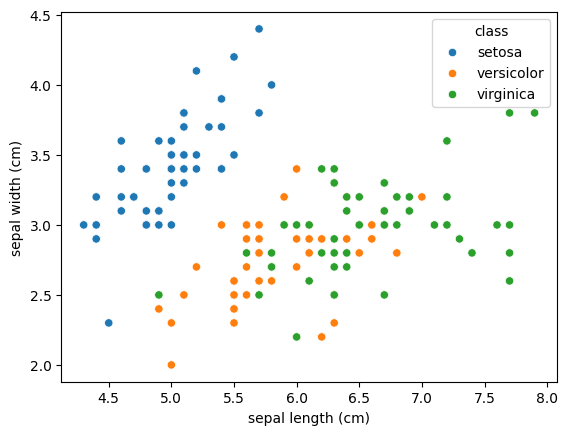

In [1]:
import seaborn as sns
import pandas as pd
from sklearn import datasets

# Get data
iris = datasets.load_iris(as_frame=True)
df = iris.frame
df['class'] = pd.Categorical.from_codes(iris.target, iris.target_names)

# Plot data
sns.scatterplot(data=df, x='sepal length (cm)', y='sepal width (cm)', hue="class");

The goal of our model is to classify the flowering plants based on the two features shown in the plot (sepal length and width). Which of the following is true about the model and task at hand?

In [2]:
from jupyterquiz import display_quiz
display_quiz('quiz/iris.json')

<IPython.core.display.Javascript object>

## Validation Sets

```{margin}
Hyperparameters are parameters that are not learned from the data but set by the researcher before the training process.
```

The simplest form of cross validation is to simply split the dataset into two parts:

- *Training set*: Part of the data used for training
- *Validation set*: Part of the data used for testing (e.g. across different models and hyperparameters<sup>{{hyperparam}}</sup>)


```{figure} figures/ValidationSet.drawio.png
:name: VS
:alt: Validation set approach
:align: center

The validation set splits the dataset into a training and a testing set (these do not necessarily need to be of equal size).
```

The training and testing set neither need to be of equal size nor do they need to be contiguous blocks in the data. Let's try the validation set approach on the `Iris` data:

1.  Define features and target data

In [3]:
iris = datasets.load_iris(as_frame=True)

# Features: sepal length and width; target: type of flower
X = df[["sepal length (cm)", "sepal width (cm)"]] 
y = df["target"]

2. Split the data into training and test samples

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

3. Fit the model (we use a support vector classifier which you will learn about later in the seminar)

In [5]:
from sklearn import svm

model = svm.SVC(kernel='linear')
fit = model.fit(X_train, y_train)

4. Evaluate model performance

In [6]:
fit.score(X_test, y_test)

0.85

The `score()` method returns the accuray of our predictions. In this case, our algorithm correctly predicted the species of the flower in 85% of cases.

In [7]:
from jupytercards import display_flashcards
display_flashcards('quiz/validation_set.json');

<IPython.core.display.Javascript object>

**Hands on**: In the editor below, we perform a classification for two splits in the the data. Please modify the code to first use 80% of the data for testing and 20% for training, and second to use 20% for training and 80% for testing. Before evaluating each model, think about what kind of results you would expect. Which model do you think will perform better?

<iframe src="https://trinket.io/embed/python3/48c2802e1e16" width="100%" height="356" frameborder="0" marginwidth="0" marginheight="0" allowfullscreen></iframe>

```{admonition} Summary
:class: hint

The validation set approach is a quick and easy way to check how well a model performs. However, it has a major flaw: it puts all its trust in a single data split which can doom a great model or trick us into thinking a weak model performs better than it actually does.
```

## Cross Validation (CV)

### K-fold CV

To get more robust performance estimates, we need something smarter. Rather than worrying about if the split of data used for training and validation is biased, we will perform this splitting multiple times and use all of the splits in turn.

In k-fold CV we randomly dive the dataset into $k$ equal-sized folds. In each fold, one sample is then designated as the validation set, while the remaining $k-1$ samples are the training sets. The fitting process is repeated $k$-times, each time using a different fold as the validation set. At the end of the process, we can compute the average accuracy across all validation sets to obtain a more reliable estimate of the model's overall performance.

```{figure} figures/CV.drawio.png
:name: CV
:alt: Cross validation
:align: center

K-fold cross validation splits the dataset into $k$ equally sized parts and then trains the model on all possible combinations of it, keeping the proportion of train/test data constant.
```

Let`s try it on our data:

In [8]:
from sklearn.model_selection import KFold, cross_val_score

k_fold = KFold(n_splits = 5)
model = svm.SVC(kernel='linear')

scores = cross_val_score(model, X, y, cv=k_fold) 

print(f"Average accuracy:    {scores.mean()}")
print(f"Individual accuracies: {scores}")

Average accuracy:    0.6133333333333334
Individual accuracies: [1.         0.8        0.3        0.76666667 0.2       ]


If we are interested in the exact models, we can also run the training and evaluation explicitly which allows us to save the models:

In [9]:
from sklearn.base import clone

base_model = svm.SVC(kernel='linear')
score_list = []
model_list =  []

for train_index, test_index in k_fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] # iloc because X is a df
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] # iloc because y is a df

    model = clone(base_model) # create a new copy of the model for every iteration
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    score_list.append(score)
    model_list.append(model)

print(f"Best performing model in split {score_list.index(max(score_list))}.")
print(f"Accuracy: {max(score_list)}")

Best performing model in split 0.
Accuracy: 1.0


```{admonition} Validatation set vs. k-fold
:class: note

Comparing the two approaches, we see that the validation set approach shows a higher accuracy compared to CV. This tells us that our initial estimates were probably overly optimistic.
```

**Try it yourself**: Change the number of folds $k$ and observe how the predicitions change. What do you feel like is a good tradeoff between bias and variance?

<iframe src="https://trinket.io/embed/python3/c46516cf56de" width="100%" height="356" frameborder="0" marginwidth="0" marginheight="0" allowfullscreen></iframe>

```{admonition} The choice of $k$
:class: note 

Choosing an appropriate k involves a tradeoff between bias, variance, and computational cost. A higher k generally provides a more stable and reliable estimate but comes with higher computational cost and also requires a sufficiently big dataset to still have a representative test set.
 
Generally speaking, $k=5$ or $k=10$ are common choices.
```

### Leave-one-out CV (LOOCV)

LOOCV is a special case of k-fold cross validation, where $k$ equals the number of observations. In LOOCV, the model is trained on all but one data point, and the remaining single observation is used for validation. This process repeats for each data point, ensuring every observation is used for testing exactly once. 

While LOOCV provides a low-bias estimate, it is computationally expensive and may lead to high variance in model performance. The implementation is fairly similar, we just need to change the CV from `KFold()` to `LeaveOneOut()`:

In [10]:
from sklearn.model_selection import LeaveOneOut

model = svm.SVC(kernel='linear')
loocv = LeaveOneOut()

scores = cross_val_score(model, X, y, cv = loocv)

print(f"Average accuracy:    {scores.mean()}")
print(f"Indidual accuracies: {scores}")

Average accuracy:    0.8
Indidual accuracies: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0.
 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 0.]


## Side Note: Bootstrapping

Bootstrapping is a resampling technique used to estimate the sampling distribution of an estimator by repeatedly drawing samples — *with replacement* — from the original dataset. In the context of machine learning, bootstrapping is often used to assess the variability and uncertainty of model performance (for the purpose of estimating the prediction accuracies, k-fold CV is generally preferred). Unlike traditional cross-validation, which partitions the dataset into distinct training and validation sets, bootstrapping creates multiple training sets by sampling the data with replacement. In each iteration, the model is trained on the bootstrap sample, and the out-of-bag (OOB) samples (i.e., the observations not included in that particular bootstrap sample) are used as a surrogate for the validation set. Generally, a larger number of iterations would be performed in real applications, but we here outline the concept with 10 iterations:

In [11]:
import numpy as np
import pandas as pd
from sklearn import datasets, svm
from sklearn.utils import resample

# Load the data
iris = datasets.load_iris(as_frame=True)
df = iris.frame

n_iterations = 10
scores = []

for i in range(n_iterations):
    # Create a bootstrap sample
    bootstrap_sample = resample(df, replace=True, n_samples=len(df), random_state=i)
    
    # Determine the out-of-bag (OOB) samples: rows not in the bootstrap sample.
    oob_indices = df.index.difference(bootstrap_sample.index)
    
    # If no OOB samples are available, skip this iteration.
    if len(oob_indices) == 0:
        print(f"Iteration {i+1}: No out-of-bag samples, skipping iteration.")
        continue
    
    oob_sample = df.loc[oob_indices]
    
    # Define features and target for training and testing
    X_train = bootstrap_sample[["sepal length (cm)", "sepal width (cm)"]]
    y_train = bootstrap_sample["target"]
    X_test = oob_sample[["sepal length (cm)", "sepal width (cm)"]]
    y_test = oob_sample["target"]
    
    # Train and evaluate the model
    model = svm.SVC(kernel='linear')
    model.fit(X_train, y_train)
    
    score = model.score(X_test, y_test)
    scores.append(score)
    print(f"Iteration {i+1}: Accuracy = {score:.3f}")

print("\nMean Accuracy:", np.mean(scores))

Iteration 1: Accuracy = 0.774
Iteration 2: Accuracy = 0.825
Iteration 3: Accuracy = 0.759
Iteration 4: Accuracy = 0.817
Iteration 5: Accuracy = 0.818
Iteration 6: Accuracy = 0.778
Iteration 7: Accuracy = 0.827
Iteration 8: Accuracy = 0.729
Iteration 9: Accuracy = 0.807
Iteration 10: Accuracy = 0.839

Mean Accuracy: 0.7971433155841059
